Load env

In [2]:
from dotenv import load_dotenv
load_dotenv(dotenv_path="../.env", override=True)

True

## Configuration

In [3]:
from langsmith import Client
client = Client()
GENERATE_QUERIES_SYSTEM_PROMPT = (
    client.pull_prompt("langchain-ai/chat-langchain-generate-queries-prompt")
    .messages[0]
    .prompt.template
)

model_dict = {
    "openai/gpt-4o-mini": "openai/gpt-4o-mini",
    "google_genai/gemini-2.0-flash-exp": "google_genai/gemini-2.0-flash-exp",
    "tongyi/qwen3-32b": "tongyi/qwen3-32b",
}


In [4]:
from pydantic import BaseModel, Field
from typing import Annotated, Literal, Any

class GenerateQueriesConfiguration(BaseModel):
    """The configuration for the query generation tool."""
    query_model: str = Field(
        description="The language model used for processing and refining queries. Should be in the form: provider/model-name.",
    )
    generate_queries_system_prompt: str = Field(
        default=GENERATE_QUERIES_SYSTEM_PROMPT,
        description="The system prompt used by the researcher to generate queries based on a step in the research plan.",
    )

class RetrieveDocumentsConfiguration(BaseModel):
    """The configuration for the retrieve documents tool."""
    embedding_model: Annotated[
        str,
        {"__template_metadata__": {"kind": "embeddings"}},
    ] = Field(
            default="openai/text-embedding-3-small",
            description="Name of the embedding model to use. Must be a valid embedding model name.",
        )
    retriever_provider: Annotated[
        Literal["weaviate", "chroma", "duckdb", "supabase"],
        {"__template_metadata__": {"kind": "retriever"}},
    ] = Field(
        default="chroma",
        description="The vector store provider to use for retrieval.",
    )
    search_kwargs: dict[str, Any] = Field(
        default_factory=dict,
        description="Additional keyword arguments to pass to the search function of the retriever.",
        json_schema_extra={ "example": {"k": 4, "fetch_k": 20, "lambda_mult": 0.5, "filter": {"source": "langgraph"}}},
    )


## State

In [5]:
import uuid
from typing import Any
from pydantic import BaseModel, Field
from typing import Annotated, Optional, Union, Literal
from langchain_core.documents import Document

def reduce_docs(
    existing: Optional[list[Document]],
    new: Union[
        list[Document],
        list[dict[str, Any]],
        list[str],
        str,
        Literal["delete"],
    ],
) -> list[Document]:
    """Reduce and process documents based on the input type.

    This function handles various input types and converts them into a sequence of Document objects.
    It also combines existing documents with the new one based on the document ID.

    Args:
        existing (Optional[Sequence[Document]]): The existing docs in the state, if any.
        new (Union[Sequence[Document], Sequence[dict[str, Any]], Sequence[str], str, Literal["delete"]]):
            The new input to process. Can be a sequence of Documents, dictionaries, strings, or a single string.
    """
    if new == "delete":
        return []

    existing_list = list(existing) if existing else []
    if isinstance(new, str):
        return existing_list + [
            Document(page_content=new, metadata={"uuid": str(uuid.uuid4())})
        ]

    new_list = []
    if isinstance(new, list):
        existing_ids = set(doc.metadata.get("uuid") for doc in existing_list)
        for item in new:
            if isinstance(item, str):
                item_id = str(uuid.uuid4())
                new_list.append(Document(page_content=item, metadata={"uuid": item_id}))
                existing_ids.add(item_id)

            elif isinstance(item, dict):
                metadata = item.get("metadata", {})
                item_id = metadata.get("uuid", str(uuid.uuid4()))

                if item_id not in existing_ids:
                    new_list.append(
                        Document(**item, metadata={**metadata, "uuid": item_id})
                    )
                    existing_ids.add(item_id)

            elif isinstance(item, Document):
                item_id = item.metadata.get("uuid")
                if item_id is None:
                    item_id = str(uuid.uuid4())
                    new_item = item.model_copy(update={"metadata": {"uuid": item_id}})
                else:
                    new_item = item

                if item_id not in existing_ids:
                    new_list.append(new_item)
                    existing_ids.add(item_id)

    return existing_list + new_list

class ResearcherState(BaseModel):
    """State of the researcher graph / agent."""

    question: str
    """A step in the research plan generated by the retriever agent."""
    queries: list[str] = Field(default_factory=list)
    """A list of search queries based on the question that the researcher generates."""
    documents: Annotated[list[Document], reduce_docs] = Field(default_factory=list)
    """Populated by the retriever. This is a list of documents that the agent can reference."""


## Tools

### Queries Generator

In [ ]:

import os
from langchain_core.language_models import BaseChatModel
from langchain_community.chat_models import ChatTongyi
from langchain.chat_models import init_chat_model
from langchain_core.runnables import RunnableConfig
from langsmith import trace
from pydantic import BaseModel, Field

def load_chat_model(fully_specified_name: str) -> tuple[BaseChatModel, str, str]:
    """Load a chat model from a fully specified name.

    Args:
        fully_specified_name (str): String in the format 'provider/model'.
    """
    if "/" in fully_specified_name:
        provider, name = fully_specified_name.split("/", maxsplit=1)
    else:
        provider = ""
        name = fully_specified_name

    model_kwargs = {"temperature": 0}
    if provider == "google_genai":
        # google doesn't support system message
        model_kwargs["convert_system_message_to_human"] = True
    if provider == "tongyi":
        # init_chat_model doesn't support tongyi
        return ChatTongyi(name=name, model_kwargs=model_kwargs), provider, name
    return init_chat_model(name, model_provider=provider, **model_kwargs), provider, name


class Response(BaseModel):
    """Response of the generate queries tool."""

    queries: list[str] = Field(description="The list of generated search queries, at most 3.")


async def generate_queries(
    state: ResearcherState, *, config: RunnableConfig
) -> Response:
    """Generate search queries based on the question (a step in the research plan).

    This function uses a language model to generate diverse search queries to help answer the question.

    Args:
        state (QuestionState): The current state of the researcher, including the user's question.
        config (RunnableConfig): Configuration with the model used to generate queries.

    Returns:
        Response: A Pydantic model with a 'queries' key containing the list of generated search queries.
    """

    configuration = GenerateQueriesConfiguration.model_validate(config.get("configurable"))
    structured_output_kwargs = (
        {"method": "function_calling"} if "openai" in configuration.query_model else {}
    )
    model, provider, name = load_chat_model(configuration.query_model)
    model = model.with_structured_output(Response, **structured_output_kwargs)

    async with trace(
        name="generate_queries",
        run_type="tool",
        inputs={"Question": state.question},
        metadata={
            "ls_provider": provider,
            "ls_model": name,
        }
    ) as ls_trace:
        messages = [
            {"role": "system", "content": configuration.generate_queries_system_prompt},
            {"role": "human", "content": state.question},
        ]
        response = await model.ainvoke(messages, {"tags": ["langsmith:nostream"]})
        ls_trace.end(outputs={"queries": response.queries})
    return response

In [7]:
config: RunnableConfig = {
    "configurable": {
        "query_model": "openai/gpt-4o-mini",
        "generate_queries_system_prompt": GENERATE_QUERIES_SYSTEM_PROMPT,
    }
}

# test generate queries
researcher_state = ResearcherState(question="What is the capital of France?")
response = generate_queries(researcher_state, config=config)
await response

Response(queries=['What is the capital city of France?', 'France capital information', 'Paris as the capital of France'])

### Documents Retriever

In [51]:
from typing import Annotated, Literal, Any, Iterator
from pydantic import BaseModel, Field
from contextlib import contextmanager
from langchain_core.embeddings import Embeddings
from langchain_core.retrievers import BaseRetriever
from langchain_core.runnables import RunnableConfig
from langchain_chroma import Chroma
from langchain_community.vectorstores.duckdb import DuckDB
from langchain_weaviate import WeaviateVectorStore
import os
import chromadb
import duckdb
import weaviate
# warning: 这三个向量数据库存在和protobuf不兼容的问题，需要固定5.29.0版本

class QueryState(BaseModel):
    """Private state for the retrieve_documents node in the researcher graph."""

    query: str = Field(description="The query string.")

def make_text_encoder(model: str) -> Embeddings:
    """Connect to the configured text encoder."""
    provider, model = model.split("/", maxsplit=1)
    match provider:
        case "openai":
            from langchain_openai import OpenAIEmbeddings

            return OpenAIEmbeddings(model=model)
        case _:
            raise ValueError(f"Unsupported embedding provider: {provider}")

@contextmanager
def make_chroma_retriever(
    configuration: RetrieveDocumentsConfiguration, embedding_model: Embeddings
) -> Iterator[BaseRetriever]:
    """Ref: https://python.langchain.com/api_reference/chroma/vectorstores/langchain_chroma.vectorstores.Chroma.html
            https://python.langchain.com/docs/integrations/vectorstores/chroma/#running-locally-with-data-persistence-1"""
    chroma_client = chromadb.PersistentClient(
        path=os.environ["CHROMA_PATH"],
    )
    store = Chroma(
            client=chroma_client,
            collection_name="LangChain_Combined_Docs_OpenAI_text_embedding_3_small",
            embedding_function=embedding_model,
            persist_directory=os.environ["CHROMA_PATH"],
        )
    # help(store.as_retriever) # debug
    search_kwargs = {**configuration.search_kwargs} # "return_uuids" 不支持
    retriever = store.as_retriever(search_kwargs=search_kwargs)
    try:
        yield retriever
    finally:
        pass 

@contextmanager
def make_weaviate_retriever(
    configuration: RetrieveDocumentsConfiguration, embedding_model: Embeddings
) -> Iterator[BaseRetriever]:
    """Ref: https://weaviate-python-client.readthedocs.io/en/latest/weaviate.html#weaviate.connect_to_embedded"""
    with weaviate.connect_to_embedded(
        persistence_data_path=os.environ["WEAVIATE_PATH"],
        binary_path=os.environ["WEAVIATE_PATH"],
        environment_variables={"LOG_LEVEL": "error"}
    ) as weaviate_client:
        store = WeaviateVectorStore(
            client=weaviate_client,
            index_name="LangChain_Combined_Docs_OpenAI_text_embedding_3_small",
            text_key="text",
            embedding=embedding_model,
            attributes=["source", "title"],
        )
        # help(store.as_retriever) # debug
        search_kwargs = {**configuration.search_kwargs, "return_uuids": True}
        yield store.as_retriever(search_kwargs=search_kwargs)

@contextmanager
def make_duckdb_retriever(
    configuration: RetrieveDocumentsConfiguration, embedding_model: Embeddings
) -> Iterator[BaseRetriever]:
    """Ref: https://python.langchain.com/api_reference/community/vectorstores/langchain_community.vectorstores.duckdb.DuckDB.html
            https://duckdb.org/docs/stable/clients/python/overview.html#persistent-storage"""
    with duckdb.connect(
        database=os.environ["DUCKDB_PATH"],
        config={
        # secure configuration
            "enable_external_access": "false",
            "autoinstall_known_extensions": "false",
            "autoload_known_extensions": "false"
        }
    ) as duckdb_client:
        store = DuckDB(
            connection=duckdb_client,
            table_name="LangChain_Combined_Docs_OpenAI_text_embedding_3_small",
            embedding=embedding_model,
        )
        # help(store.as_retriever) # debug
        search_kwargs = {**configuration.search_kwargs, "return_uuids": True}
        yield store.as_retriever(search_kwargs=search_kwargs)

@contextmanager
def make_retriever(
    config: RunnableConfig,
) -> Iterator[BaseRetriever]:
    """Create a retriever for the agent, based on the current configuration."""
    configuration = RetrieveDocumentsConfiguration.model_validate(config.get("configurable"))
    embedding_model = make_text_encoder(configuration.embedding_model)
    match configuration.retriever_provider:
        case "weaviate":
            with make_weaviate_retriever(configuration, embedding_model) as retriever:
                yield retriever
        case "chroma":
            with make_chroma_retriever(configuration, embedding_model) as retriever:
                yield retriever
        case "duckdb":
            with make_duckdb_retriever(configuration, embedding_model) as retriever:
                yield retriever
        case _:
            raise ValueError(
                "Unrecognized retriever_provider in configuration. "
                f"Expected one of: {', '.join(BaseConfiguration.__annotations__['retriever_provider'].__args__)}\n"
                f"Got: {configuration.retriever_provider}"
            )


In [52]:
from langgraph.constants import Send

async def retrieve_documents(
    state: QueryState, *, config: RunnableConfig
) -> dict[str, list[Document]]:
    """Retrieve documents based on a given query.

    This function uses a retriever to fetch relevant documents for a given query.

    Args:
        state (QueryState): The current state containing the query string.
        config (RunnableConfig): Configuration with the retriever used to fetch documents.

    Returns:
        dict[str, list[Document]]: A dictionary with a 'documents' key containing the list of retrieved documents.
    """
    with make_retriever(config) as retriever:
        response = await retriever.ainvoke(state.query, config)
        return {"documents": response}

def retrieve_in_parallel(state: ResearcherState) -> list[Send]:
    """Create parallel retrieval tasks for each generated query.

    This function prepares parallel document retrieval tasks for each query in the researcher's state.

    Args:
        state (ResearcherState): The current state of the researcher, including the generated queries.

    Returns:
        Literal["retrieve_documents"]: A list of Send objects, each representing a document retrieval task.

    Behavior:
        - Creates a Send object for each query in the state.
        - Each Send object targets the "retrieve_documents" node with the corresponding query.
    """
    return [
        Send("retrieve_documents", QueryState(query=query)) for query in state.queries
    ]

In [58]:
# test
config: RunnableConfig = {
    "configurable": {
        "embedding_model": "openai/text-embedding-3-small",
        "retriever_provider": "weaviate",
        "search_kwargs": {"k": 6},
    }
}

# test generate queries
researcher_state = ResearcherState(
    question="What is the capital of France?", 
    queries=['What is the capital city of France?', 'France capital information', 'Paris as the capital of France'], 
    documents=[]
    )

all_docs = []
for query in researcher_state.queries:
    result = await retrieve_documents(QueryState(query=query), config=config)
    all_docs = reduce_docs(all_docs, result["documents"])

final_docs = {"documents": all_docs}

print(final_docs)


{"build_git_commit":"62dcafac32","build_go_version":"go1.24.3","build_image_tag":"HEAD","build_wv_version":"1.30.5","error":"cannot find peer","level":"error","msg":"transferring leadership","time":"2025-07-29T11:20:18+02:00"}
{"build_git_commit":"62dcafac32","build_go_version":"go1.24.3","build_image_tag":"HEAD","build_wv_version":"1.30.5","error":"cannot find peer","level":"error","msg":"transferring leadership","time":"2025-07-29T11:20:25+02:00"}


{'documents': []}


{"build_git_commit":"62dcafac32","build_go_version":"go1.24.3","build_image_tag":"HEAD","build_wv_version":"1.30.5","error":"cannot find peer","level":"error","msg":"transferring leadership","time":"2025-07-29T11:20:32+02:00"}


## Define the researcher graph

In [59]:
from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph


builder = StateGraph(ResearcherState)
builder.add_node(generate_queries)
builder.add_node(retrieve_documents)
builder.add_edge(START, "generate_queries")
builder.add_conditional_edges(
    "generate_queries",
    retrieve_in_parallel,  # type: ignore
    path_map=["retrieve_documents"],
)
builder.add_edge("retrieve_documents", END)
graph = builder.compile()
graph.name = "ResearcherGraph"


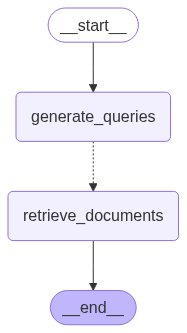

In [60]:
# draw graph
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))